## Chapter 3.2 codes. This notebook was used for first iteration and second iteration in chapter 3.2.1 and 3.2.2


#### 1. Importing dataset and filtering to defined timespan

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
df = pd.read_csv('Inputdata31.csv')
import plotly.express as px
cutoff_date = pd.Timestamp("2025-1-1")
df["CloseDateNew"] = pd.to_datetime(df["CloseDateNew"]) 
# Filter the rows
#filtered_df = df[(df["Created date"] > cutoff_date ) & (df["CloseDateNew"] > cutoff_date)]
data= df[df["CloseDateNew"] > cutoff_date]
data = data[data["IsClosed"] == 1]
data["Created date"] = pd.to_datetime(data["Created date"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID                              0 non-null      float64       
 1   IsClosed                        0 non-null      float64       
 2   IsWon                           0 non-null      float64       
 3   CloseDateNew                    0 non-null      datetime64[ns]
 4   Created date                    0 non-null      datetime64[ns]
 5   Customer                        0 non-null      float64       
 6   MarketSegmentc                  0 non-null      float64       
 7   BusinessType                    0 non-null      float64       
 8   Industryc                       0 non-null      float64       
 9   Subsegmentc                     0 non-null      float64       
 10  Ownerrolec                      0 non-null      float64       
 11  Paymentterm            

#### 2. Investigating null values and dropping unnecessary rows

In [79]:
missing = data.isnull().sum()
missing_pct = (missing / len(data) * 100).round(2)
missing_summary = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values('Missing %', ascending=True)
# Show top 10 fields with most missing data
display(missing_summary)

,Missing Count,Missing %
ID,0,NaN
IsClosed,0,NaN
IsWon,0,NaN
CloseDateNew,0,NaN
Created date,0,NaN
Customer,0,NaN
MarketSegmentc,0,NaN
BusinessType,0,NaN
Industryc,0,NaN
Subsegmentc,0,NaN


In [66]:
# List of columns to explicitly drop
explicit_drop = [
  
    'CloseDateNew',
    'Customer',
  'ID',  'IsClosed', 'Probability']
# Find columns with >80% missing values
missing_pct = data.isnull().sum() / len(data) * 100
high_missing = missing_pct[missing_pct > 80].index.tolist()
# Combine all columns to drop (avoid duplicates)
cols_to_drop = list(set(explicit_drop + high_missing))
# Drop columns from the DataFrame
data_cleaned = data.drop(columns=cols_to_drop)

In [67]:
import pandas as pd
from IPython.display import display
# Calculate missing values and percentage for each column
missing_counts = data_cleaned.isnull().sum()
missing_pct = (missing_counts / len(data_cleaned) * 100).round(2)
# Combine into a summary DataFrame
missing_summary = pd.DataFrame({
    'Missing Values': missing_counts,
    'Missing %': missing_pct
})
# Display the table
display(missing_summary)

,Missing Values,Missing %
IsWon,0,0.00
Created date,0,0.00
MarketSegmentc,0,0.00
BusinessType,209,3.12
Industryc,27,0.40
Subsegmentc,4144,61.85
Ownerrolec,118,1.76
Paymentterm,235,3.51
throughput,0,0.00
Variant cluster,0,0.00


### 3. Preprocessing of missing values
For catecorigal features missing are filled with "Unknown" and for numerical values filled with median

In [68]:
for col in data_cleaned.select_dtypes(include='object').columns:
    data_cleaned[col] = data_cleaned[col].fillna('Unknown')
# Impute numeric columns with median
for col in data_cleaned.select_dtypes(include=['float64', 'int64']).columns:
    if data_cleaned[col].isnull().any():
        median_val = data_cleaned[col].median()
        data_cleaned[col] = data_cleaned[col].fillna(median_val)

In [69]:
from IPython.display import display
summary = pd.DataFrame({
    'Unique Values': data_cleaned.nunique(dropna=True),
    'Missing Values': data_cleaned.isnull().sum(),
    'Missing %': (data_cleaned.isnull().sum() / len(data) * 100).round(2),
    'Data Type': data_cleaned.dtypes.astype(str)
})
# Optional: sort by unique values
summary = summary.sort_values('Unique Values', ascending=False)
# Display as a DataFrame in the notebook
display(summary)

,Unique Values,Missing Values,Missing %,Data Type
Created date,6455,0,0.0,datetime64[ns]
Oppo value,5280,0,0.0,float64
EstimatedQuoteMargin,4631,0,0.0,float64
throughput,847,0,0.0,int64
Variant cluster,285,0,0.0,int64
Subsegmentc,108,0,0.0,object
Ownerrolec,65,0,0.0,object
Industryc,53,0,0.0,object
Activity count,41,0,0.0,int64
Paymentterm,15,0,0.0,object


In [70]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6700 entries, 0 to 114487
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   IsWon                           6700 non-null   int64         
 1   Created date                    6700 non-null   datetime64[ns]
 2   MarketSegmentc                  6700 non-null   object        
 3   BusinessType                    6700 non-null   object        
 4   Industryc                       6700 non-null   object        
 5   Subsegmentc                     6700 non-null   object        
 6   Ownerrolec                      6700 non-null   object        
 7   Paymentterm                     6700 non-null   object        
 8   throughput                      6700 non-null   int64         
 9   Variant cluster                 6700 non-null   int64         
 10  Activity count                  6700 non-null   int64         
 11  Oppo va

#### 4. Encoding the categorical features 
One hot encoding will be used to transform text values to numerical

In [71]:
#this is part is done due to the sensoring purposes in real production version you dont need to numerize the content first
#in production a plain get dummies can be used. 
import pandas as pd

# List of categorical features to encode
categorical_features = [
    'MarketSegmentc', 'BusinessType', 'Industryc', 
    'Subsegmentc', 'Ownerrolec', 'Paymentterm'
]

# Make a copy of the dataframe
df_encoded = data_cleaned.copy()

# Replace category names with numeric codes
for col in categorical_features:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

df_encoded = pd.get_dummies(df_encoded, columns=categorical_features, prefix=categorical_features, drop_first=False)
df_encoded.head()

# Check result
df_encoded.head()


,IsWon,Created date,throughput,Variant cluster,Activity count,Oppo value,EstimatedQuoteMargin,Value selling field proportion,BigDealAlertSent,Tenderflag,...,Paymentterm_5,Paymentterm_6,Paymentterm_7,Paymentterm_8,Paymentterm_9,Paymentterm_10,Paymentterm_11,Paymentterm_12,Paymentterm_13,Paymentterm_14
0,1,2025-08-07 12:56:11,1,48,6,6803.87,96.929117,0.000000,0,0,...,False,False,False,False,False,False,True,False,False,False
1,1,2025-08-07 06:54:11,0,-1,8,10760.00,69.970353,0.142857,0,0,...,False,False,False,False,False,False,False,False,False,False
2,1,2025-08-06 14:54:44,1,161,6,34815.31,71.780645,0.000000,0,0,...,True,False,False,False,False,False,False,False,False,False
3,1,2025-08-06 11:34:15,106,3,6,2258.43,85.488975,0.000000,0,0,...,False,False,False,False,False,False,False,False,False,False
4,1,2025-08-06 09:30:57,0,161,6,216.75,100.000000,0.000000,0,0,...,False,False,False,False,False,False,False,False,False,False


#### 5.Splitting of the dataset to test and train sets

In [72]:
import pandas as pd
# Set your cutoff date, e.g., April 1, 2025
cutoff_date = pd.Timestamp('2025-04-01')
# Train: opportunities created before cutoff
# Test: opportunities created on/after cutoff
train = df_encoded[df_encoded['Created date'] < cutoff_date]
train_target = df_encoded.loc[train.index, 'IsWon']
test = df_encoded[df_encoded['Created date'] >= cutoff_date]
test_target = df_encoded.loc[test.index, 'IsWon']
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Calculate split percentages
total_samples = len(df_encoded)
train_pct = len(train) / total_samples * 100
test_pct = len(test) / total_samples * 100

print(f"Train size: {len(train)} samples ({train_pct:.2f}%)")
print(f"Test size: {len(test)} samples ({test_pct:.2f}%)")


#tarkista scikit learnin splittaus työkalut, tutustu scikit

Train shape: (4652, 272)
Test shape: (2048, 272)
Train size: 4652 samples (69.43%)
Test size: 2048 samples (30.57%)


###### Check the split

In [73]:
# Calculate class balance for train set
train_counts = train_target.value_counts()
train_percent = (train_counts / train_counts.sum() * 100).round(2)
print("Train set class balance:")
print(train_counts)
print(train_percent)
# Calculate class balance for test set
test_counts = test_target.value_counts()
test_percent = (test_counts / test_counts.sum() * 100).round(2)
print("\nTest set class balance:")
print(test_counts)
print(test_percent)

Train set class balance:
IsWon
0    2398
1    2254
Name: count, dtype: int64
IsWon
0    51.55
1    48.45
Name: count, dtype: float64

Test set class balance:
IsWon
1    1497
0     551
Name: count, dtype: int64
IsWon
1    73.1
0    26.9
Name: count, dtype: float64


In [74]:
# create the final training splits drop the created date at this point as it is not used for training only forming the dataset
X_train = train.drop(columns=['IsWon', 'Created date'])
y_train = train_target
X_test = test.drop(columns=['IsWon', 'Created date'])
y_test = test_target

#### 6. Machine learning, modeling part and 7. results

In [75]:
import pandas as pd
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, recall_score, precision_score, f1_score
)

# ---------------------------------------------------
# Helper function for evaluation
# ---------------------------------------------------
def evaluate_model(name, y_true, y_pred, y_proba):
    return {
        "Model": name,
        "ROC_AUC": roc_auc_score(y_true, y_proba),
        "PR_AUC": average_precision_score(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

results = []

# ---------------------------------------------------
# Logistic Regression (class_weight balanced)
# ---------------------------------------------------
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

results.append(
    evaluate_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
)

# ---------------------------------------------------
# Gradient Boosting Classifier
# ---------------------------------------------------
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

y_pred_gbc = gbc.predict(X_test)
y_proba_gbc = gbc.predict_proba(X_test)[:, 1]

results.append(
    evaluate_model("Gradient Boosting", y_test, y_pred_gbc, y_proba_gbc)
)

# ---------------------------------------------------
# Histogram-based Gradient Boosting
# ---------------------------------------------------
gbt = HistGradientBoostingClassifier(random_state=42)
gbt.fit(X_train, y_train)

y_pred_gbt = gbt.predict(X_test)
y_proba_gbt = gbt.predict_proba(X_test)[:, 1]

results.append(
    evaluate_model("HistGradient Boosting", y_test, y_pred_gbt, y_proba_gbt)
)

# ---------------------------------------------------
# XGBoost
# ---------------------------------------------------
xgb_clf = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

results.append(
    evaluate_model("XGBoost", y_test, y_pred_xgb, y_proba_xgb)
)

# ---------------------------------------------------
# 7. Results table and export
# ---------------------------------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("model_evaluation_results.csv", index=False)

results_df


C:\Users\OSNIE\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,ROC_AUC,PR_AUC,Accuracy,Recall,Precision,F1
0,Logistic Regression,0.903983,0.932406,0.901367,0.975952,0.897972,0.935339
1,Gradient Boosting,0.961319,0.980086,0.935059,0.975952,0.937741,0.956465
2,HistGradient Boosting,0.966839,0.979216,0.944336,0.983300,0.942985,0.962721
3,XGBoost,0.966299,0.981967,0.941406,0.975952,0.945631,0.960552


### 7. Plotting SHAP and feature importance for analysis

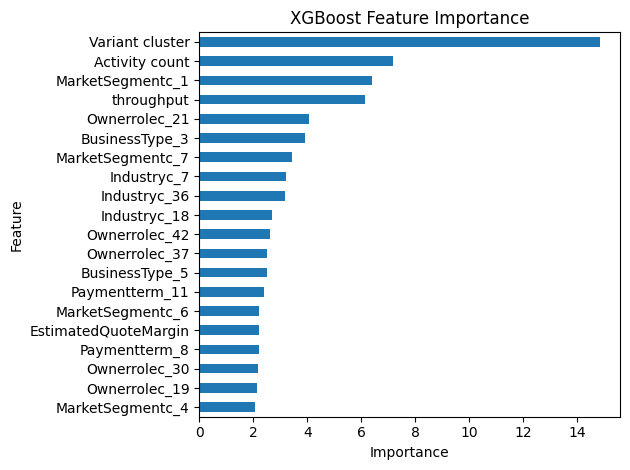

In [76]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance (gain-based, recommended)
importance = xgb_clf.get_booster().get_score(importance_type='gain')

# Convert to DataFrame
importance_df = (
    pd.DataFrame.from_dict(importance, orient='index', columns=['Gain'])
      .sort_values(by='Gain', ascending=False)
)

# Plot top 20 features
importance_df.head(20).plot(kind='barh', legend=False)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

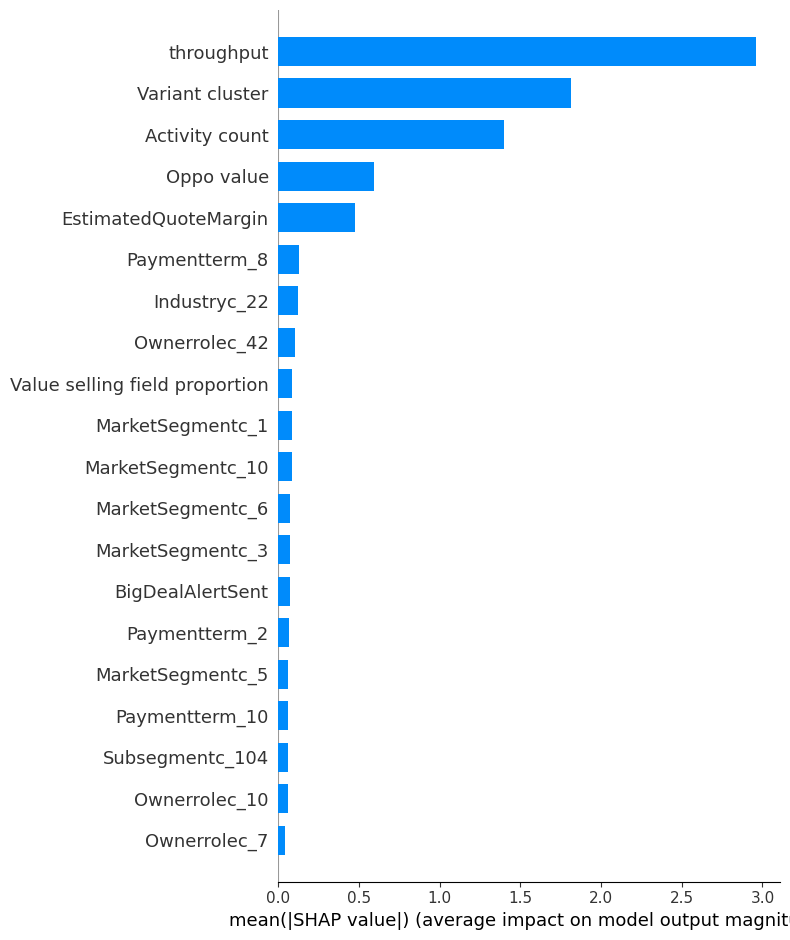

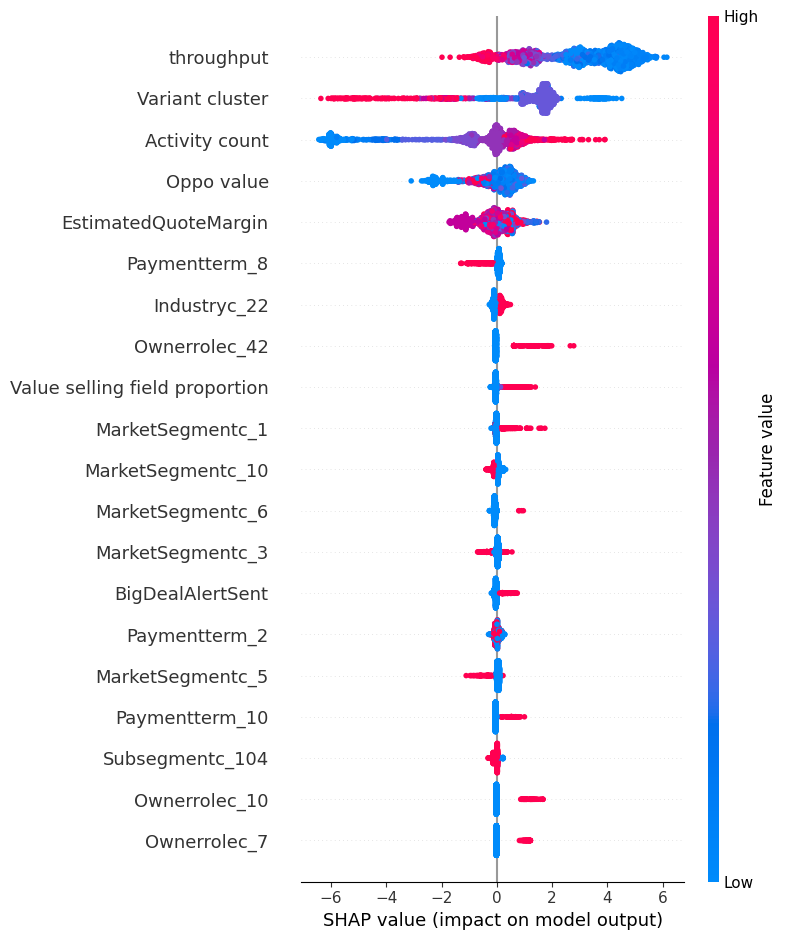

In [77]:
import shap
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)
# Summary plot (feature importance)
shap.summary_plot(shap_values, X_test, plot_type="bar")
# Detailed summary plot (beeswarm)
shap.summary_plot(shap_values, X_test)